In [2]:
import pandas
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

In [5]:
import os
print(os.getcwd())

/home/samuelebumbaca/projects/PhD_thesis/Anomaly_detection


In [6]:
# Load the CSV files into dataframes
model_comparison_df = pandas.read_csv('model_comparison_results.csv')
clusterization_results_df = pandas.read_csv('clusterization_results.csv')

# Display the first few rows of each dataframe to verify the import
print(model_comparison_df.head())
print(clusterization_results_df.head())

        Dataset        Model DimReduction  Dimensions    AnomalyMethod  \
0  plantvillage  densenet121         tsne         2.0           IQR+CI   
1  plantvillage  densenet121         tsne         2.0  IsolationForest   
2  plantvillage  densenet121         tsne         2.0      OneClassSVM   
3  plantvillage  densenet121         tsne         2.0              LOF   
4  plantvillage  densenet121         tsne         2.0              GMM   

   Accuracy  Precision    Recall        F1       AUC  
0     0.862   0.991903  0.785256  0.876565  0.887309  
1     0.854   0.931408  0.826923  0.876061  0.862930  
2     0.860   0.923077  0.846154  0.882943  0.864566  
3     0.868   0.976744  0.807692  0.884211  0.887889  
4     0.860   0.991870  0.782051  0.874552  0.885706  
        Dataset        Model DimReduction  Dimensions ClusterizationMethod  \
0  plantvillage  densenet121         tsne           2               KMeans   
1  plantvillage  densenet121         tsne           2         Hierarc

In [7]:
village_anomaly_df = model_comparison_df[model_comparison_df['Dataset'] == 'plantvillage']
village_anomaly_df = village_anomaly_df[village_anomaly_df['Dimensions'] == 1]
village_anomaly_bench = village_anomaly_df[village_anomaly_df['Accuracy'] >= 0.85]
pathology_anomaly_df = model_comparison_df[model_comparison_df['Dataset'] == 'plantpathology']
pathology_anomaly_df = pathology_anomaly_df[pathology_anomaly_df['Dimensions'] == 1]
pathology_anomaly_bench = pathology_anomaly_df[pathology_anomaly_df['Accuracy'] >= 0.85]

Saved: Plant_Village_Dataset_Anomaly_Detection_Performance.pdf


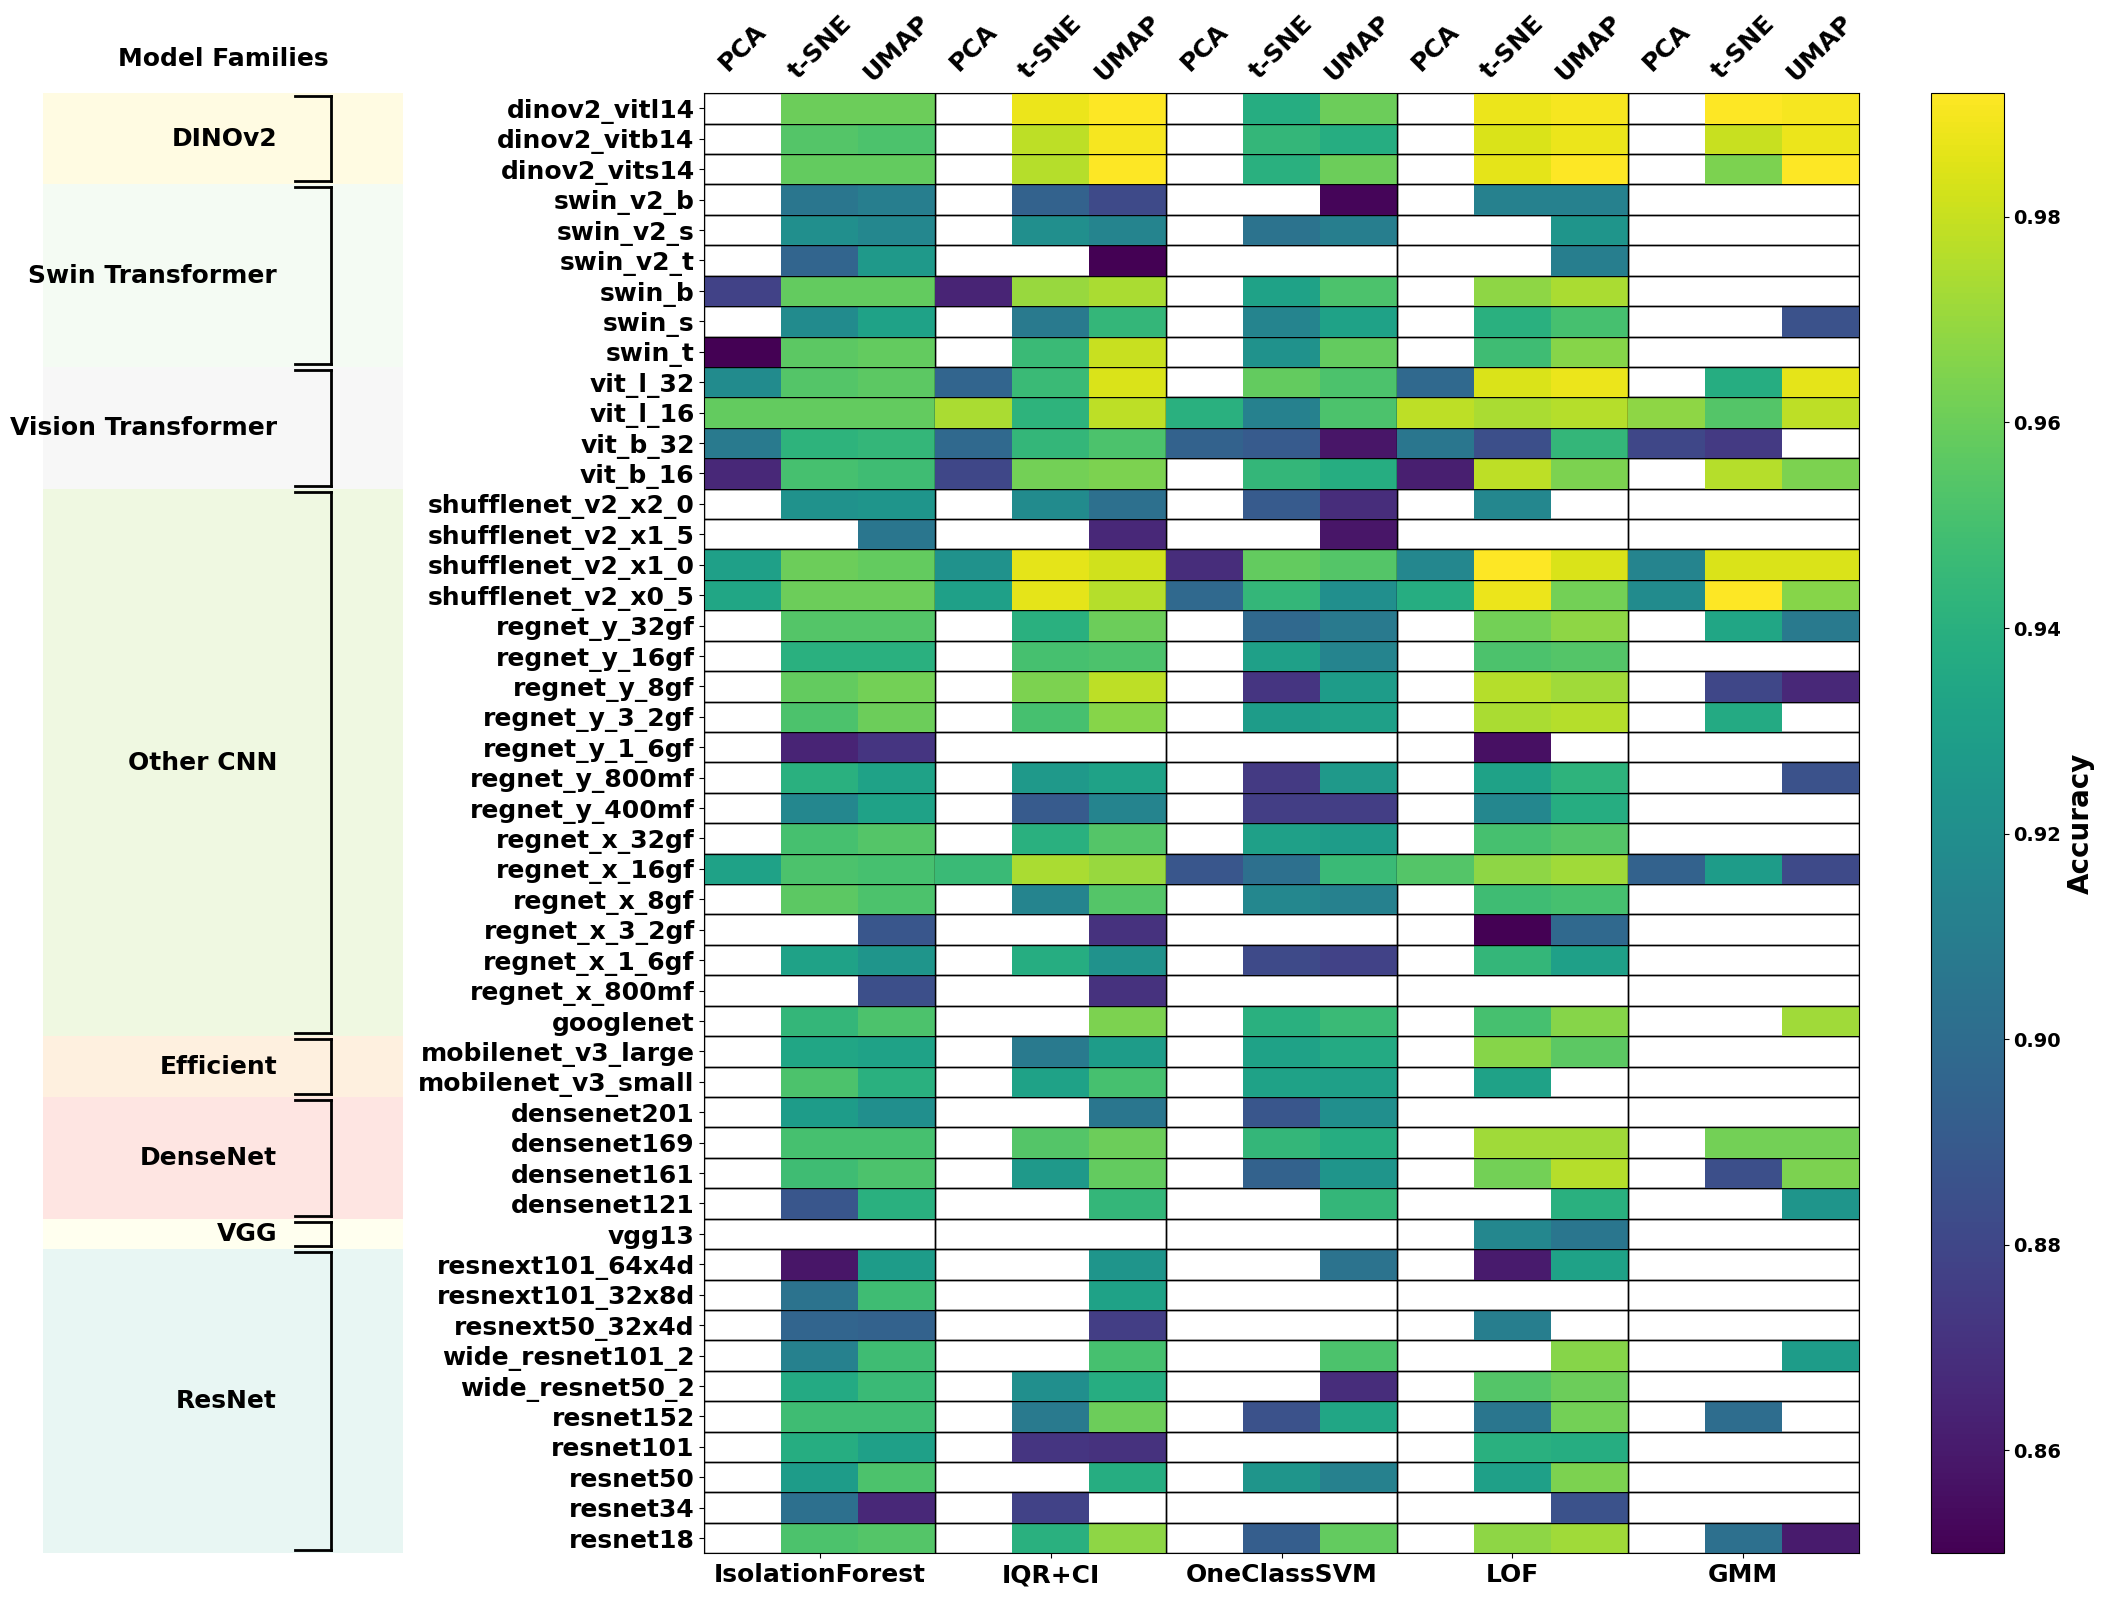

In [39]:
# Define model families and their order based on the paper
model_families = {
    'ResNet': ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 
               'wide_resnet50_2', 'wide_resnet101_2', 'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_64x4d'],
    'VGG': ['vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'],
    'DenseNet': ['densenet121', 'densenet161', 'densenet169', 'densenet201'],
    'Efficient': ['mobilenet_v3_small', 'mobilenet_v3_large'],
    'Other CNN': ['googlenet', 'inception_v3', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_1_6gf', 'regnet_x_3_2gf',
                  'regnet_x_8gf', 'regnet_x_16gf', 'regnet_x_32gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_1_6gf',
                  'regnet_y_3_2gf', 'regnet_y_8gf', 'regnet_y_16gf', 'regnet_y_32gf', 'shufflenet_v2_x0_5',
                  'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0'],
    'Vision Transformer': ['vit_b_16', 'vit_b_32', 'vit_l_16', 'vit_l_32'],
    'Swin Transformer': ['swin_t', 'swin_s', 'swin_b', 'swin_v2_t', 'swin_v2_s', 'swin_v2_b'],
    'DINOv2': ['dinov2_vits14', 'dinov2_vitb14', 'dinov2_vitl14']
}

# Create ordered list of models based on families
ordered_models = []
family_boundaries = {}
current_pos = 0

for family, models in model_families.items():
    # Filter models that exist in the data
    existing_models = [m for m in models if m in village_anomaly_bench['Model'].values]
    if existing_models:
        family_boundaries[family] = (current_pos, current_pos + len(existing_models) - 1)
        ordered_models.extend(existing_models)
        current_pos += len(existing_models)

# Get other data for plotting
anomaly_methods = village_anomaly_bench['AnomalyMethod'].unique()
dim_reductions = sorted(village_anomaly_bench['DimReduction'].unique())

# Map dimension reduction names to proper formatting
dim_reduction_mapping = {'pca': 'PCA', 'tsne': 't-SNE', 'umap': 'UMAP'}
formatted_dim_reductions = [dim_reduction_mapping.get(dr.lower(), dr) for dr in dim_reductions]

# Create figure with Model Families on the left
fig, (ax_tree, ax) = plt.subplots(1, 2, figsize=(22, 16), gridspec_kw={'width_ratios': [1, 4]})

# Create a pivot table with multi-index
pivot_data = village_anomaly_bench.pivot_table(
    index='Model', 
    columns=['AnomalyMethod', 'DimReduction'], 
    values='Accuracy'
)

# Set up the color normalization based on the range of accuracy values
norm = Normalize(village_anomaly_bench['Accuracy'].min(), village_anomaly_bench['Accuracy'].max())

# Draw grid cells
for i, model in enumerate(ordered_models):
    for j, method in enumerate(anomaly_methods):
        # Create a cell outline
        rect = patches.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        
        # Divide each cell into 3 parts for each dimension reduction technique
        for k, dim_red in enumerate(dim_reductions):
            try:
                # Get the accuracy value
                accuracy = pivot_data.loc[model, (method, dim_red)]
                
                # Check if the value exists
                if not pd.isna(accuracy):
                    # Create a sub-rectangle for this dimension reduction method
                    sub_rect = patches.Rectangle(
                        (j + k/3, i),  # x, y
                        1/3, 1,        # width, height
                        linewidth=0,
                        edgecolor='none',
                        facecolor=viridis(norm(accuracy))
                    )
                    ax.add_patch(sub_rect)
            except (KeyError, ValueError):
                # This combination might not exist in the data
                pass

# Set up the main plot axes
ax.set_xlim(0, len(anomaly_methods))
ax.set_ylim(0, len(ordered_models))
ax.set_xticks(np.arange(len(anomaly_methods)) + 0.5)
ax.set_yticks(np.arange(len(ordered_models)) + 0.5)
ax.set_xticklabels(anomaly_methods, fontsize=18, fontweight='bold')
ax.set_yticklabels(ordered_models, fontsize=18, fontweight='bold')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Accuracy', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=14)
# Make colorbar tick labels bold
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

# Add DimReduction labels on top of the columns with proper formatting
for j, method in enumerate(anomaly_methods):
    for k, (dim_red, formatted_dim_red) in enumerate(zip(dim_reductions, formatted_dim_reductions)):
        ax.text(j + k/3 + 1/6, len(ordered_models) + 1.5, formatted_dim_red, ha='center', va='center', 
                rotation=45, fontsize=18, fontweight='bold')

# Create family tree on the left
ax_tree.set_xlim(0, 2)
ax_tree.set_ylim(0, len(ordered_models))

# Define colors for different families
family_colors = plt.cm.Set3(np.linspace(0, 1, len(model_families)))

# Draw family groupings and tree
for idx, (family, (start, end)) in enumerate(family_boundaries.items()):
    # Draw family bracket
    y_center = (start + end) / 2 + 0.5
    y_start = start + 0.1
    y_end = end + 0.9
    
    # Vertical line
    ax_tree.plot([1.6, 1.6], [y_start, y_end], 'k-', linewidth=2)
    # Horizontal lines
    ax_tree.plot([1.4, 1.6], [y_start, y_start], 'k-', linewidth=2)
    ax_tree.plot([1.4, 1.6], [y_end, y_end], 'k-', linewidth=2)
    # Family name
    ax_tree.text(1.3, y_center, family, va='center', ha='right', fontsize=18, fontweight='bold')
    
    # Color background for family
    family_rect = patches.Rectangle((0, start), 2, end - start + 1, 
                                  facecolor=family_colors[idx], alpha=0.2, edgecolor='none')
    ax_tree.add_patch(family_rect)

# Remove tree axes
ax_tree.set_xticks([])
ax_tree.set_yticks([])
ax_tree.spines['top'].set_visible(False)
ax_tree.spines['right'].set_visible(False)
ax_tree.spines['bottom'].set_visible(False)
ax_tree.spines['left'].set_visible(False)

# Set only the tree title
ax_tree.set_title('Model Families', fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()

# Save as PDF
plt.savefig('Plant_Village_Dataset_Anomaly_Detection_Performance.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
print("Saved: Plant_Village_Dataset_Anomaly_Detection_Performance.pdf")

plt.show()

Saved: Plant_Pathology_Dataset_Anomaly_Detection_Performance.pdf


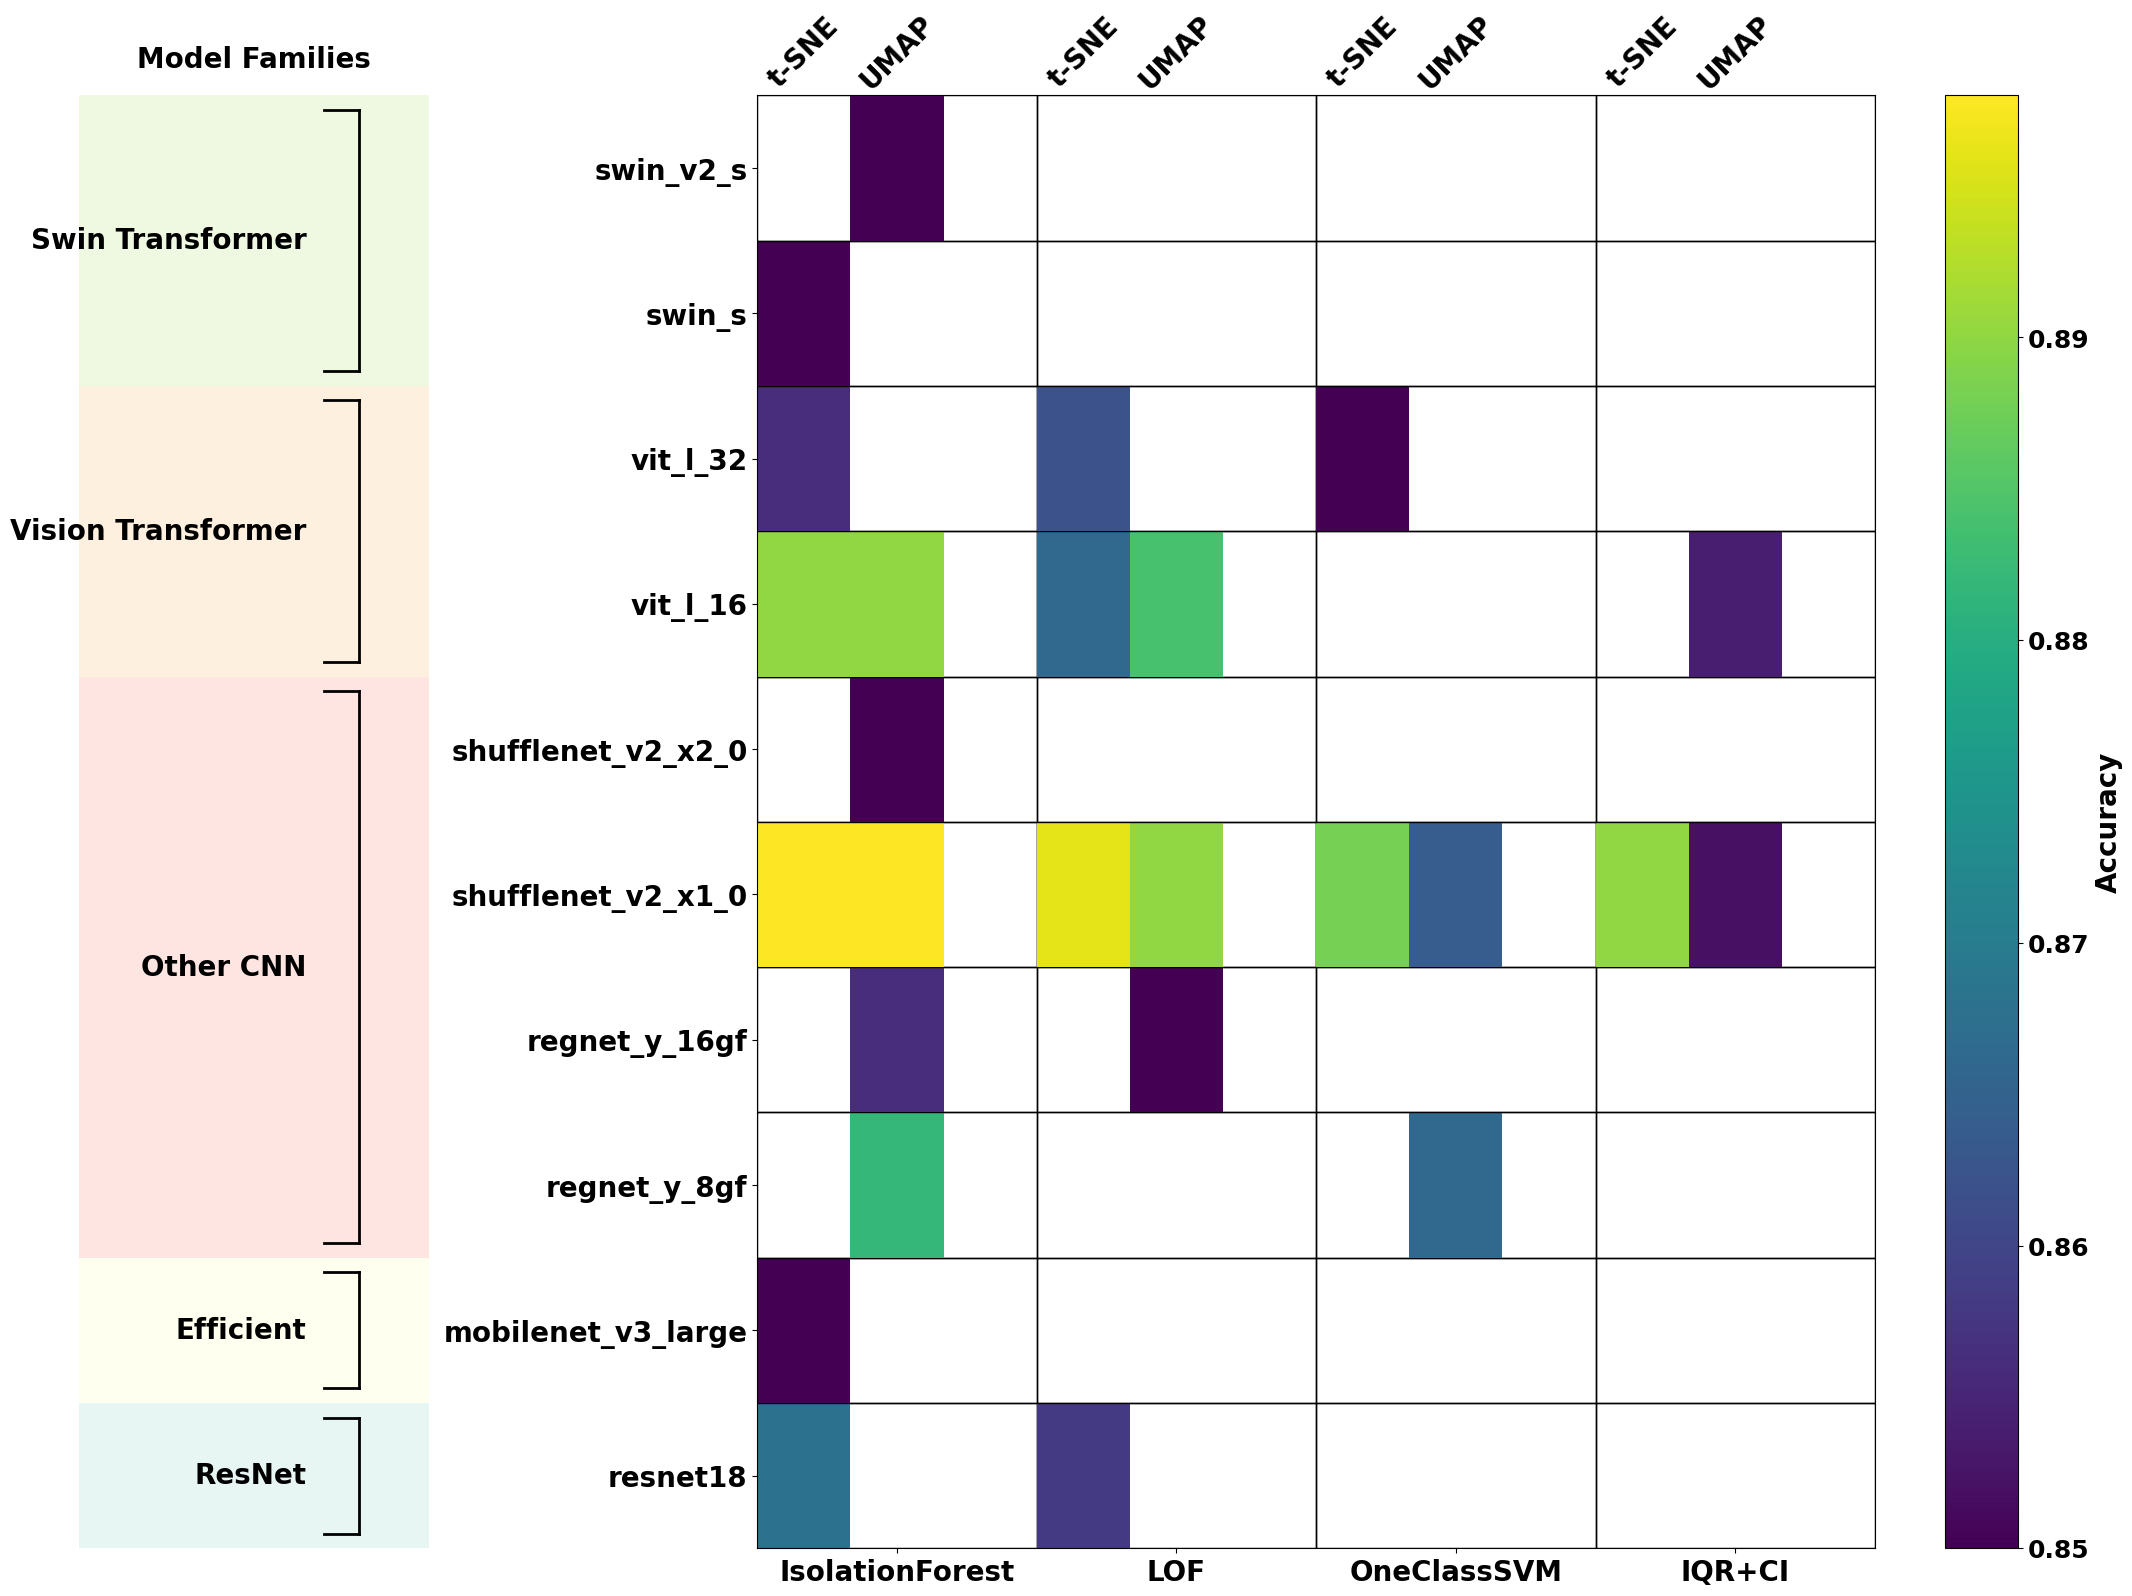

In [42]:
# Use the same model ordering as defined above
pathology_ordered_models = []
pathology_family_boundaries = {}
current_pos = 0

for family, models in model_families.items():
    # Filter models that exist in the pathology data
    existing_models = [m for m in models if m in pathology_anomaly_bench['Model'].values]
    if existing_models:
        pathology_family_boundaries[family] = (current_pos, current_pos + len(existing_models) - 1)
        pathology_ordered_models.extend(existing_models)
        current_pos += len(existing_models)

# Get other data for plotting
anomaly_methods = pathology_anomaly_bench['AnomalyMethod'].unique()
dim_reductions = sorted(pathology_anomaly_bench['DimReduction'].unique())

# Map dimension reduction names to proper formatting
dim_reduction_mapping = {'pca': 'PCA', 'tsne': 't-SNE', 'umap': 'UMAP'}
formatted_dim_reductions = [dim_reduction_mapping.get(dr.lower(), dr) for dr in dim_reductions]

# Create figure with Model Families on the left
fig, (ax_tree, ax) = plt.subplots(1, 2, figsize=(22, 16), gridspec_kw={'width_ratios': [1, 4]})

# Create a pivot table with multi-index
pivot_data = pathology_anomaly_bench.pivot_table(
    index='Model', 
    columns=['AnomalyMethod', 'DimReduction'], 
    values='Accuracy'
)

# Set up the color normalization based on the range of accuracy values
norm = Normalize(pathology_anomaly_bench['Accuracy'].min(), pathology_anomaly_bench['Accuracy'].max())

# Draw grid cells
for i, model in enumerate(pathology_ordered_models):
    for j, method in enumerate(anomaly_methods):
        # Create a cell outline
        rect = patches.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        
        # Divide each cell into 3 parts for each dimension reduction technique
        for k, dim_red in enumerate(dim_reductions):
            try:
                # Get the accuracy value
                accuracy = pivot_data.loc[model, (method, dim_red)]
                
                # Check if the value exists
                if not pd.isna(accuracy):
                    # Create a sub-rectangle for this dimension reduction method
                    sub_rect = patches.Rectangle(
                        (j + k/3, i),  # x, y
                        1/3, 1,        # width, height
                        linewidth=0,
                        edgecolor='none',
                        facecolor=viridis(norm(accuracy))
                    )
                    ax.add_patch(sub_rect)
            except (KeyError, ValueError):
                # This combination might not exist in the data
                pass

# Set up the main plot axes
ax.set_xlim(0, len(anomaly_methods))
ax.set_ylim(0, len(pathology_ordered_models))
ax.set_xticks(np.arange(len(anomaly_methods)) + 0.5)
ax.set_yticks(np.arange(len(pathology_ordered_models)) + 0.5)
ax.set_xticklabels(anomaly_methods, fontsize=20, fontweight='bold')
ax.set_yticklabels(pathology_ordered_models, fontsize=20, fontweight='bold')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Accuracy', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=18)
# Make colorbar tick labels bold
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

# Add DimReduction labels on top of the columns with proper formatting
for j, method in enumerate(anomaly_methods):
    for k, (dim_red, formatted_dim_red) in enumerate(zip(dim_reductions, formatted_dim_reductions)):
        ax.text(j + k/3 + 1/6, len(pathology_ordered_models) + 0.3, formatted_dim_red, ha='center', va='center', 
                rotation=45, fontsize=20, fontweight='bold')

# Create family tree on the left
ax_tree.set_xlim(0, 2)
ax_tree.set_ylim(0, len(pathology_ordered_models))

# Define colors for different families
family_colors = plt.cm.Set3(np.linspace(0, 1, len(model_families)))

# Draw family groupings and tree
for idx, (family, (start, end)) in enumerate(pathology_family_boundaries.items()):
    # Draw family bracket
    y_center = (start + end) / 2 + 0.5
    y_start = start + 0.1
    y_end = end + 0.9
    
    # Vertical line
    ax_tree.plot([1.6, 1.6], [y_start, y_end], 'k-', linewidth=2)
    # Horizontal lines
    ax_tree.plot([1.4, 1.6], [y_start, y_start], 'k-', linewidth=2)
    ax_tree.plot([1.4, 1.6], [y_end, y_end], 'k-', linewidth=2)
    # Family name
    ax_tree.text(1.3, y_center, family, va='center', ha='right', fontsize=20, fontweight='bold')
    
    # Color background for family
    family_rect = patches.Rectangle((0, start), 2, end - start + 1, 
                                  facecolor=family_colors[idx], alpha=0.2, edgecolor='none')
    ax_tree.add_patch(family_rect)

# Remove tree axes
ax_tree.set_xticks([])
ax_tree.set_yticks([])
ax_tree.spines['top'].set_visible(False)
ax_tree.spines['right'].set_visible(False)
ax_tree.spines['bottom'].set_visible(False)
ax_tree.spines['left'].set_visible(False)

# Set only the tree title
ax_tree.set_title('Model Families', fontsize=20, fontweight='bold', pad=20)

plt.tight_layout()

# Save as PDF
plt.savefig('Plant_Pathology_Dataset_Anomaly_Detection_Performance.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
print("Saved: Plant_Pathology_Dataset_Anomaly_Detection_Performance.pdf")

plt.show()

In [17]:
village_clust_df = clusterization_results_df[clusterization_results_df['Dataset'] == 'plantvillage']
village_clust_df = village_clust_df[village_clust_df['Dimensions'] == 1]
village_clust_bench = village_clust_df[village_clust_df['CohenK'] >= 0.7]
pathology_clust_df = clusterization_results_df[clusterization_results_df['Dataset'] == 'plantpathology']
pathology_clust_df = pathology_clust_df[pathology_clust_df['Dimensions'] == 1]
pathology_clust_bench = pathology_clust_df[pathology_clust_df['CohenK'] >= 0.7]

Saved: Plant_Village_Dataset_Clustering_Performance.pdf


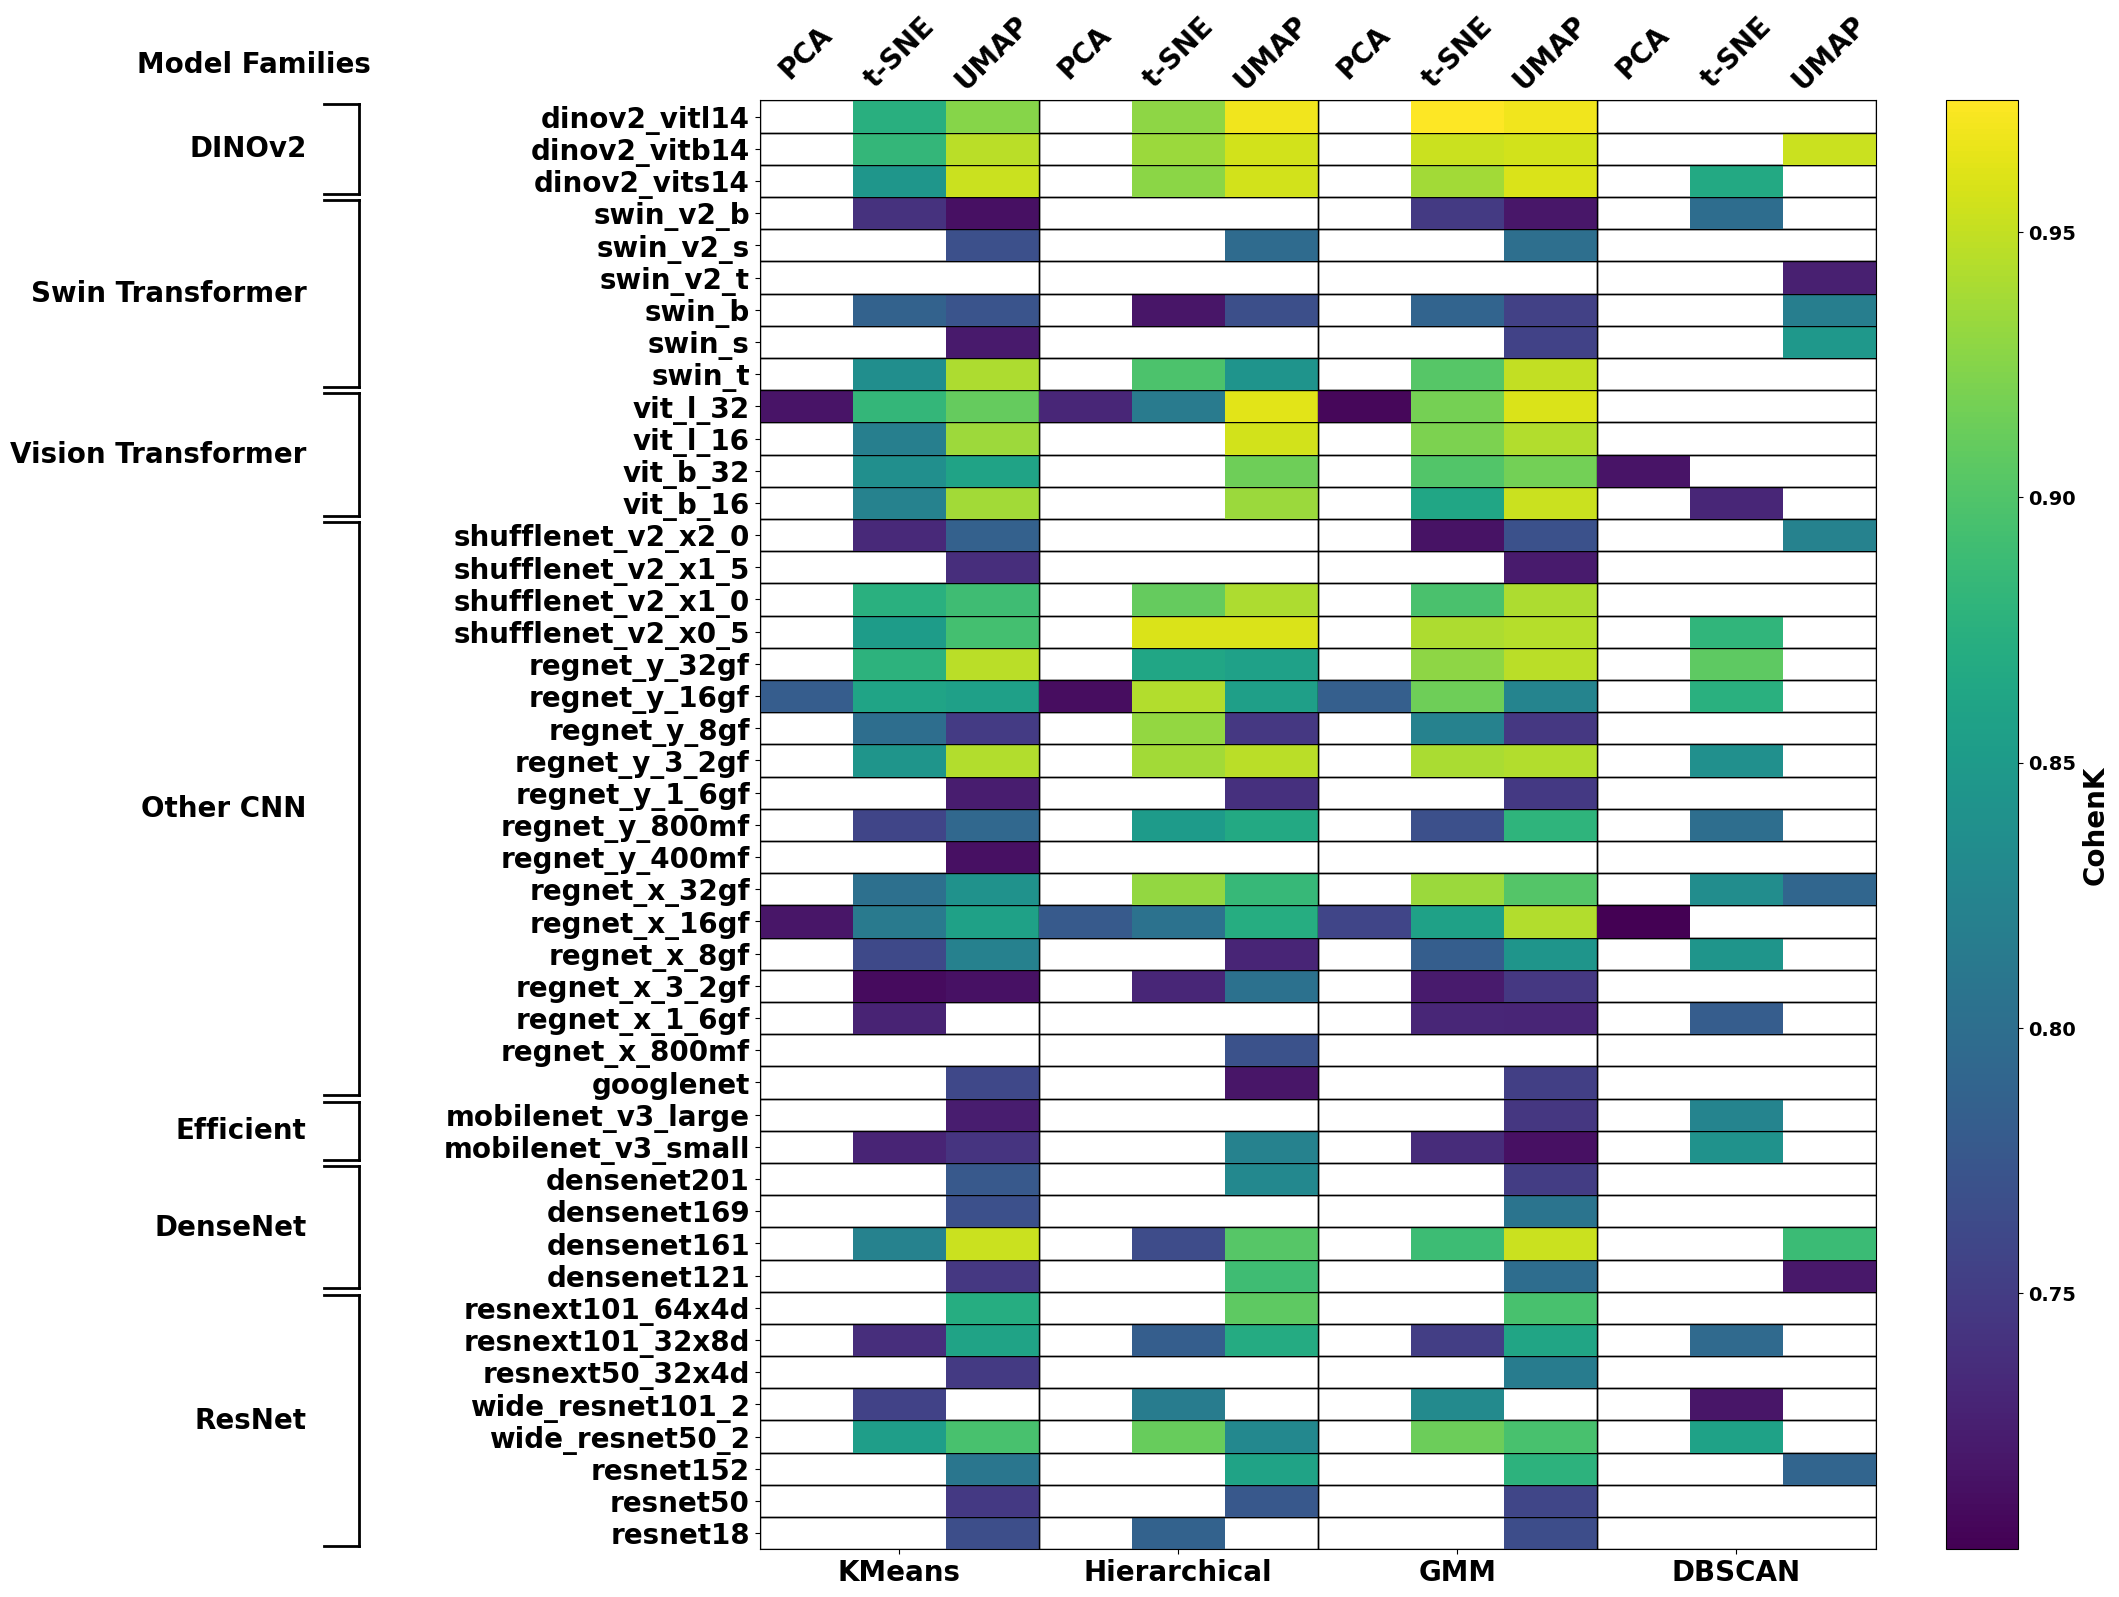

In [ ]:
# Use the same model ordering for clustering
village_clust_ordered_models = []
village_clust_family_boundaries = {}
current_pos = 0

for family, models in model_families.items():
    # Filter models that exist in the clustering data
    existing_models = [m for m in models if m in village_clust_bench['Model'].values]
    if existing_models:
        village_clust_family_boundaries[family] = (current_pos, current_pos + len(existing_models) - 1)
        village_clust_ordered_models.extend(existing_models)
        current_pos += len(existing_models)

# Get other data for plotting
cluster_methods = village_clust_bench['ClusterizationMethod'].unique()
dim_reductions = sorted(village_clust_bench['DimReduction'].unique())

# Map dimension reduction names to proper formatting
dim_reduction_mapping = {'pca': 'PCA', 'tsne': 't-SNE', 'umap': 'UMAP'}
formatted_dim_reductions = [dim_reduction_mapping.get(dr.lower(), dr) for dr in dim_reductions]

# Create figure with Model Families on the left
fig, (ax_tree, ax) = plt.subplots(1, 2, figsize=(22, 16), gridspec_kw={'width_ratios': [1, 4]})

# Create a pivot table with multi-index
pivot_data = village_clust_bench.pivot_table(
    index='Model', 
    columns=['ClusterizationMethod', 'DimReduction'], 
    values='CohenK'
)

# Set up the color normalization based on the range of CohenK values
norm = Normalize(village_clust_bench['CohenK'].min(), village_clust_bench['CohenK'].max())

# Draw grid cells
for i, model in enumerate(village_clust_ordered_models):
    for j, method in enumerate(cluster_methods):
        # Create a cell outline
        rect = patches.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        
        # Divide each cell into 3 parts for each dimension reduction technique
        for k, dim_red in enumerate(dim_reductions):
            try:
                # Get the CohenK value
                cohenk = pivot_data.loc[model, (method, dim_red)]
                
                # Check if the value exists
                if not pd.isna(cohenk):
                    # Create a sub-rectangle for this dimension reduction method
                    sub_rect = patches.Rectangle(
                        (j + k/3, i),  # x, y
                        1/3, 1,        # width, height
                        linewidth=0,
                        edgecolor='none',
                        facecolor=viridis(norm(cohenk))
                    )
                    ax.add_patch(sub_rect)
            except (KeyError, ValueError):
                # This combination might not exist in the data
                pass

# Set up the main plot axes
ax.set_xlim(0, len(cluster_methods))
ax.set_ylim(0, len(village_clust_ordered_models))
ax.set_xticks(np.arange(len(cluster_methods)) + 0.5)
ax.set_yticks(np.arange(len(village_clust_ordered_models)) + 0.5)
ax.set_xticklabels(cluster_methods, fontsize=20, fontweight='bold')
ax.set_yticklabels(village_clust_ordered_models, fontsize=20, fontweight='bold')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('CohenK', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=14)
# Make colorbar tick labels bold
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

# Add DimReduction labels on top of the columns with proper formatting
for j, method in enumerate(cluster_methods):
    for k, (dim_red, formatted_dim_red) in enumerate(zip(dim_reductions, formatted_dim_reductions)):
        ax.text(j + k/3 + 1/6, len(village_clust_ordered_models) + 1.5, formatted_dim_red, ha='center', va='center', 
                rotation=45, fontsize=20, fontweight='bold')

# Create family tree on the left
ax_tree.set_xlim(0, 2)
ax_tree.set_ylim(0, len(village_clust_ordered_models))

# Define colors for different families
family_colors = plt.cm.Set3(np.linspace(0, 1, len(model_families)))

# Draw family groupings and tree
for idx, (family, (start, end)) in enumerate(village_clust_family_boundaries.items()):
    # Draw family bracket
    y_center = (start + end) / 2 + 0.5
    y_start = start + 0.1
    y_end = end + 0.9
    
    # Vertical line
    ax_tree.plot([1.6, 1.6], [y_start, y_end], 'k-', linewidth=2)
    # Horizontal lines
    ax_tree.plot([1.4, 1.6], [y_start, y_start], 'k-', linewidth=2)
    ax_tree.plot([1.4, 1.6], [y_end, y_end], 'k-', linewidth=2)
    # Family name
    ax_tree.text(1.3, y_center, family, va='center', ha='right', fontsize=20, fontweight='bold')
    
    # Color background for family
    family_rect = patches.Rectangle((0, start), 2, end - start + 1, 
                                  facecolor=family_colors[idx], alpha=0.2, edgecolor='none')
    ax_tree.add_patch(family_rect)

# Remove tree axes
ax_tree.set_xticks([])
ax_tree.set_yticks([])
ax_tree.spines['top'].set_visible(False)
ax_tree.spines['right'].set_visible(False)
ax_tree.spines['bottom'].set_visible(False)
ax_tree.spines['left'].set_visible(False)

# Set only the tree title
ax_tree.set_title('Model Families', fontsize=20, fontweight='bold', pad=20)

plt.tight_layout()

# Save as PDF
plt.savefig('Plant_Village_Dataset_Clustering_Performance.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
print("Saved: Plant_Village_Dataset_Clustering_Performance.pdf")

plt.show()

Saved: Plant_Pathology_Dataset_Clustering_Performance.pdf


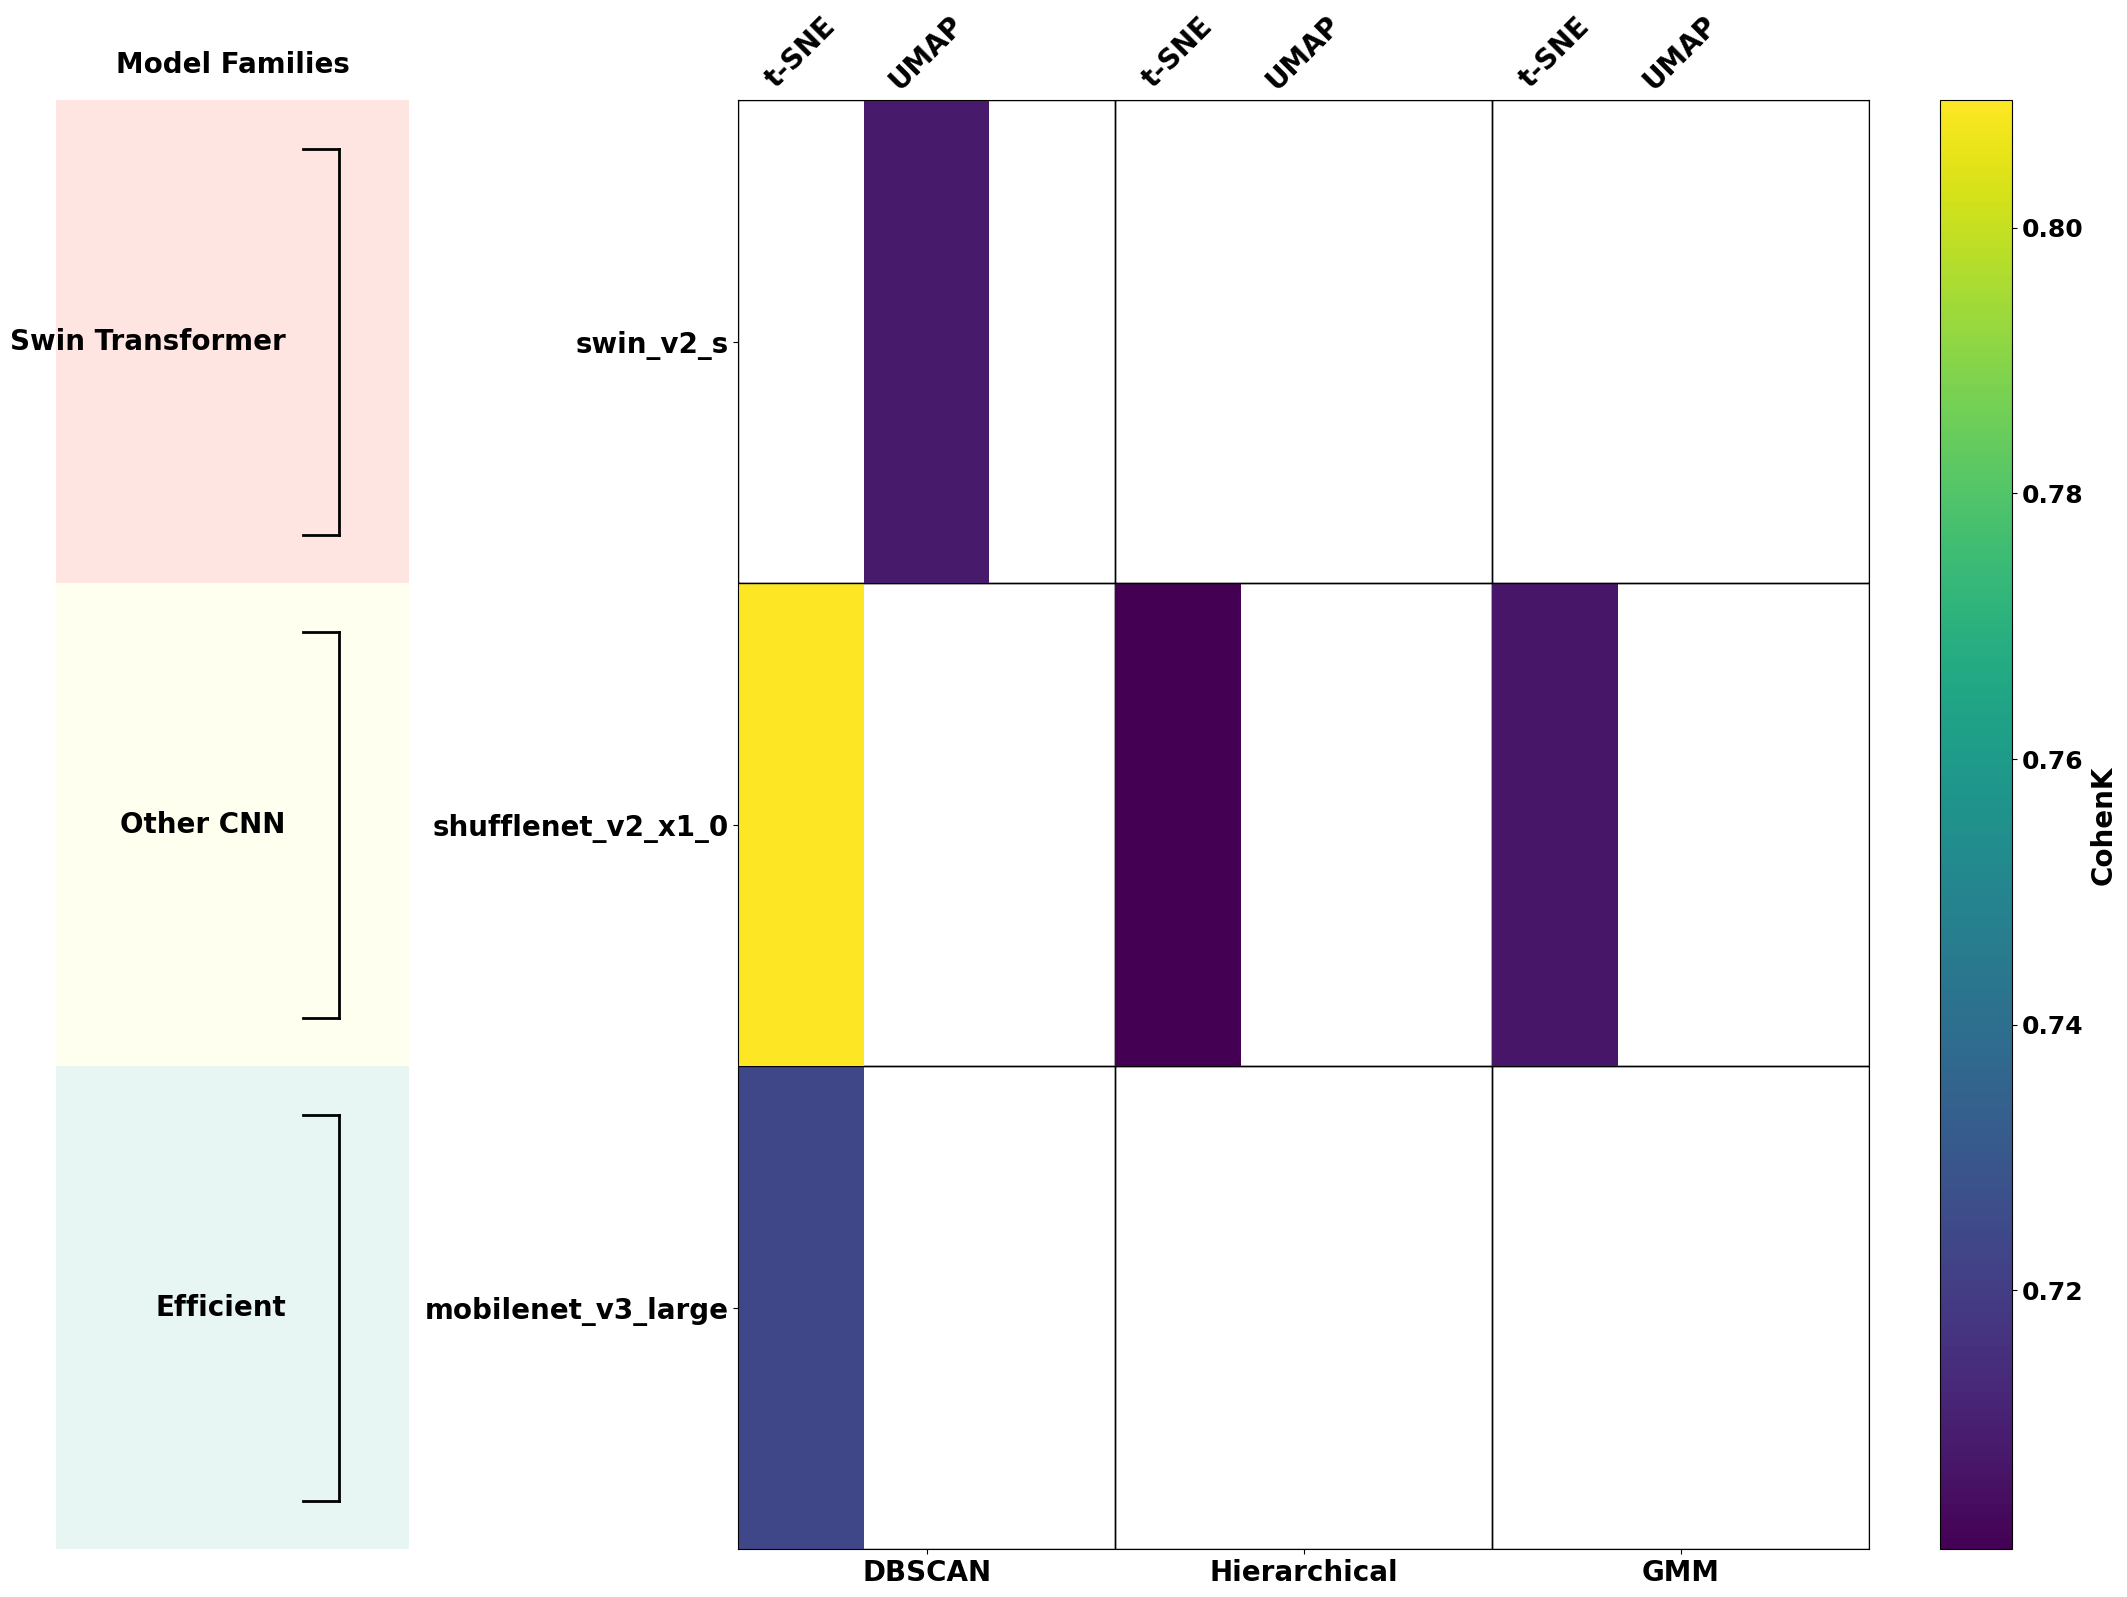

In [44]:
# Use the same model ordering for pathology clustering
pathology_clust_ordered_models = []
pathology_clust_family_boundaries = {}
current_pos = 0

for family, models in model_families.items():
    # Filter models that exist in the pathology clustering data
    existing_models = [m for m in models if m in pathology_clust_bench['Model'].values]
    if existing_models:
        pathology_clust_family_boundaries[family] = (current_pos, current_pos + len(existing_models) - 1)
        pathology_clust_ordered_models.extend(existing_models)
        current_pos += len(existing_models)

# Get other data for plotting
cluster_methods = pathology_clust_bench['ClusterizationMethod'].unique()
dim_reductions = sorted(pathology_clust_bench['DimReduction'].unique())

# Map dimension reduction names to proper formatting
dim_reduction_mapping = {'pca': 'PCA', 'tsne': 't-SNE', 'umap': 'UMAP'}
formatted_dim_reductions = [dim_reduction_mapping.get(dr.lower(), dr) for dr in dim_reductions]

# Create figure with Model Families on the left
fig, (ax_tree, ax) = plt.subplots(1, 2, figsize=(22, 16), gridspec_kw={'width_ratios': [1, 4]})

# Create a pivot table with multi-index
pivot_data = pathology_clust_bench.pivot_table(
    index='Model', 
    columns=['ClusterizationMethod', 'DimReduction'], 
    values='CohenK'
)

# Set up the color normalization based on the range of CohenK values
norm = Normalize(pathology_clust_bench['CohenK'].min(), pathology_clust_bench['CohenK'].max())

# Draw grid cells
for i, model in enumerate(pathology_clust_ordered_models):
    for j, method in enumerate(cluster_methods):
        # Create a cell outline
        rect = patches.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        
        # Divide each cell into 3 parts for each dimension reduction technique
        for k, dim_red in enumerate(dim_reductions):
            try:
                # Get the CohenK value
                cohenk = pivot_data.loc[model, (method, dim_red)]
                
                # Check if the value exists
                if not pd.isna(cohenk):
                    # Create a sub-rectangle for this dimension reduction method
                    sub_rect = patches.Rectangle(
                        (j + k/3, i),  # x, y
                        1/3, 1,        # width, height
                        linewidth=0,
                        edgecolor='none',
                        facecolor=viridis(norm(cohenk))
                    )
                    ax.add_patch(sub_rect)
            except (KeyError, ValueError):
                # This combination might not exist in the data
                pass

# Set up the main plot axes
ax.set_xlim(0, len(cluster_methods))
ax.set_ylim(0, len(pathology_clust_ordered_models))
ax.set_xticks(np.arange(len(cluster_methods)) + 0.5)
ax.set_yticks(np.arange(len(pathology_clust_ordered_models)) + 0.5)
ax.set_xticklabels(cluster_methods, fontsize=20, fontweight='bold')
ax.set_yticklabels(pathology_clust_ordered_models, fontsize=20, fontweight='bold')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('CohenK', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=18)
# Make colorbar tick labels bold
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

# Add DimReduction labels on top of the columns with proper formatting
for j, method in enumerate(cluster_methods):
    for k, (dim_red, formatted_dim_red) in enumerate(zip(dim_reductions, formatted_dim_reductions)):
        ax.text(j + k/3 + 1/6, len(pathology_clust_ordered_models) + 0.1, formatted_dim_red, ha='center', va='center', 
                rotation=45, fontsize=20, fontweight='bold')

# Create family tree on the left
ax_tree.set_xlim(0, 2)
ax_tree.set_ylim(0, len(pathology_clust_ordered_models))

# Define colors for different families
family_colors = plt.cm.Set3(np.linspace(0, 1, len(model_families)))

# Draw family groupings and tree
for idx, (family, (start, end)) in enumerate(pathology_clust_family_boundaries.items()):
    # Draw family bracket
    y_center = (start + end) / 2 + 0.5
    y_start = start + 0.1
    y_end = end + 0.9
    
    # Vertical line
    ax_tree.plot([1.6, 1.6], [y_start, y_end], 'k-', linewidth=2)
    # Horizontal lines
    ax_tree.plot([1.4, 1.6], [y_start, y_start], 'k-', linewidth=2)
    ax_tree.plot([1.4, 1.6], [y_end, y_end], 'k-', linewidth=2)
    # Family name
    ax_tree.text(1.3, y_center, family, va='center', ha='right', fontsize=20, fontweight='bold')
    
    # Color background for family
    family_rect = patches.Rectangle((0, start), 2, end - start + 1, 
                                  facecolor=family_colors[idx], alpha=0.2, edgecolor='none')
    ax_tree.add_patch(family_rect)

# Remove tree axes
ax_tree.set_xticks([])
ax_tree.set_yticks([])
ax_tree.spines['top'].set_visible(False)
ax_tree.spines['right'].set_visible(False)
ax_tree.spines['bottom'].set_visible(False)
ax_tree.spines['left'].set_visible(False)

# Set only the tree title
ax_tree.set_title('Model Families', fontsize=20, fontweight='bold', pad=20)

plt.tight_layout()

# Save as PDF
plt.savefig('Plant_Pathology_Dataset_Clustering_Performance.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
print("Saved: Plant_Pathology_Dataset_Clustering_Performance.pdf")

plt.show()